# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

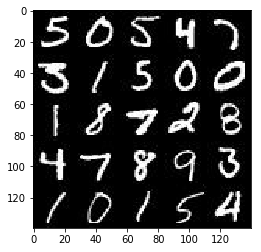

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

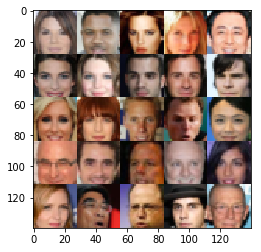

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    # discriminator
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),    
                                 name='input_real')
    # generator
    inputs_z    = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    lr          = tf.placeholder(tf.float32, shape=(),      name='lr')
                              
    return inputs_real, inputs_z, lr



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [22]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse=reuse):
        print('d images', images.get_shape().as_list())
        
        alpha = 0.2
        keep_prob = 0.7
        # input layer is 28x28x3 vs 32x32x3 in DCGAN
        # per reviewer2, pass in Xavier initalization via kernel_initializer argument
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        # NO batch normalization on first layer        
        relu1 = tf.maximum(alpha * x1, x1)
        relu1 = tf.nn.dropout(relu1, keep_prob)
        print('d x1', x1.get_shape().as_list())
        # DCGAN: 16x16x64
        # us: 14x14x128
        
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        relu2 = tf.nn.dropout(relu2, keep_prob)
        print('d x2', x2.get_shape().as_list())
        # DCGAN: 8x8x128
        # us: 7x7x256
        
        x3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.nn.dropout(relu3, keep_prob)
        print('d x3', x3.get_shape().as_list())
        # DCGAN: 4x4x256
        # SAME padding: ceil(7/2) = ceil(3.5) = 4
        # us: 4x4x512

        # flatten
        flat = tf.reshape(relu3, (-1, 4*4*512))      
        logits = tf.layers.dense(flat, 1, activation=None)
        
        # sigmoid for discriminator, r tanh for generator
        out = tf.sigmoid(logits)
        print('d logit', flat.get_shape().as_list())
            
        return out, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

d images [None, 28, 28, 3]
d x1 [None, 14, 14, 128]
d x2 [None, 7, 7, 256]
d x3 [None, 4, 4, 512]
d logit [None, 8192]
d images [None, 28, 28, 3]
d x1 [None, 14, 14, 128]
d x2 [None, 7, 7, 256]
d x3 [None, 4, 4, 512]
d logit [None, 8192]
Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [25]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    # mimic DCGAN
    alpha=0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        
        print('g z:', z)
        print('g out_channel_dim', out_channel_dim)
        
        # 1st fully connected layer
        # reviewer suggested starting w 7x7x512
        x1 = tf.layers.dense(z, 7*7*512) # passing
        print('g fully connected:', x1.get_shape().as_list())
        
        # reshape for convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        print('g x1:', x1.get_shape().as_list())
        # 7x7x512
        
        # strides = 1 here to keep height/width same
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer()) 
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        print('g x2:', x2.get_shape().as_list())
        # 7x7x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer()) 
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        print('g x3:', x3.get_shape().as_list())
        # 14x14x128
        
        # output - no batch normalization here
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same',
                                           kernel_initializer=tf.contrib.layers.xavier_initializer())

        # sigmoid for discriminator, r tanh for generator
        out = tf.tanh(logits)
        print('g logit:', logits.get_shape().as_list())
        # 28x28 x out_channel_dim
        
        return out
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

g z: Tensor("Placeholder:0", shape=(?, 100), dtype=float32)
g out_channel_dim 5
g fully connected: [None, 25088]
g x1: [None, 7, 7, 512]
g x2: [None, 7, 7, 256]
g x3: [None, 14, 14, 128]
g logit: [None, 28, 28, 5]
g z: Tensor("Placeholder:0", shape=(?, 100), dtype=float32)
g out_channel_dim 5
g fully connected: [None, 25088]
g x1: [None, 7, 7, 512]
g x2: [None, 7, 7, 256]
g x3: [None, 14, 14, 128]
g logit: [None, 28, 28, 5]
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [32]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function

    g_model = generator(input_z, out_channel_dim, is_train=True) 
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model,    reuse=True)
    
    # add some smoothing
    d_loss_real = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                       labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                       labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                       labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

g z: Tensor("Placeholder_1:0", shape=(?, 100), dtype=float32)
g out_channel_dim 4
g fully connected: [None, 25088]
g x1: [None, 7, 7, 512]
g x2: [None, 7, 7, 256]
g x3: [None, 14, 14, 128]
g logit: [None, 28, 28, 4]
d images [None, 28, 28, 4]
d x1 [None, 14, 14, 128]
d x2 [None, 7, 7, 256]
d x3 [None, 4, 4, 512]
d logit [None, 8192]
d images [None, 28, 28, 4]
d x1 [None, 14, 14, 128]
d x2 [None, 7, 7, 256]
d x3 [None, 4, 4, 512]
d logit [None, 8192]
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [33]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    # per reviewer, add control_dependencies
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [34]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [35]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    show_every = 100
    print_every = 10
    n_images = 25
    #image_channels = 3 if data_image_mode == 'RGB' else 1
    image_width    = data_shape[1]
    image_height   = data_shape[2]
    image_channels = data_shape[3]
        
    input_real, input_z, lr = model_inputs(
                                            image_width, image_height, 
                                            image_channels, z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)

    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
        
    steps = 0
    samples, losses = [], []        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                # batch is in range -0.5 to 0.5.  rescale it
                batch_images *= 2.0
            
                # random noise
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # optimizers
                # why did DCGAN flip order of input_z and input_real?  anyway
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                # run it again! per reviewer suggestion
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % print_every == 0:    
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images,
                                               lr: learning_rate})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

g z: Tensor("input_z:0", shape=(?, 128), dtype=float32)
g out_channel_dim 1
g fully connected: [None, 25088]
g x1: [None, 7, 7, 512]
g x2: [None, 7, 7, 256]
g x3: [None, 14, 14, 128]
g logit: [None, 28, 28, 1]
d images [None, 28, 28, 1]
d x1 [None, 14, 14, 128]
d x2 [None, 7, 7, 256]
d x3 [None, 4, 4, 512]
d logit [None, 8192]
d images [None, 28, 28, 1]
d x1 [None, 14, 14, 128]
d x2 [None, 7, 7, 256]
d x3 [None, 4, 4, 512]
d logit [None, 8192]
Epoch 1/2... Discriminator Loss: 3.7533... Generator Loss: 1.6761
Epoch 1/2... Discriminator Loss: 2.0462... Generator Loss: 0.6654
Epoch 1/2... Discriminator Loss: 2.5549... Generator Loss: 0.5823
Epoch 1/2... Discriminator Loss: 1.8955... Generator Loss: 0.9110
Epoch 1/2... Discriminator Loss: 1.9890... Generator Loss: 1.2404
Epoch 1/2... Discriminator Loss: 1.7590... Generator Loss: 0.8866
Epoch 1/2... Discriminator Loss: 1.9800... Generator Loss: 1.6015
Epoch 1/2... Discriminator Loss: 1.8988... Generator Loss: 0.4024
Epoch 1/2... Discriminat

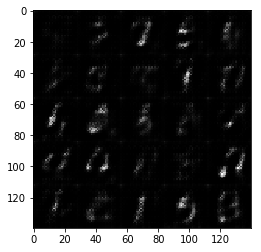

Epoch 1/2... Discriminator Loss: 1.8448... Generator Loss: 0.3382
Epoch 1/2... Discriminator Loss: 1.6500... Generator Loss: 1.1479
Epoch 1/2... Discriminator Loss: 1.4113... Generator Loss: 0.7862
Epoch 1/2... Discriminator Loss: 1.4822... Generator Loss: 1.0226
Epoch 1/2... Discriminator Loss: 1.7862... Generator Loss: 0.4850
Epoch 1/2... Discriminator Loss: 1.8558... Generator Loss: 0.7744
Epoch 1/2... Discriminator Loss: 1.5503... Generator Loss: 0.6465
Epoch 1/2... Discriminator Loss: 1.7194... Generator Loss: 0.4826
Epoch 1/2... Discriminator Loss: 1.4447... Generator Loss: 0.6055
Epoch 1/2... Discriminator Loss: 1.6005... Generator Loss: 0.6977
g z: Tensor("input_z:0", shape=(?, 128), dtype=float32)
g out_channel_dim 1
g fully connected: [None, 25088]
g x1: [None, 7, 7, 512]
g x2: [None, 7, 7, 256]
g x3: [None, 14, 14, 128]
g logit: [None, 28, 28, 1]


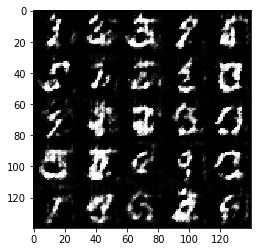

Epoch 1/2... Discriminator Loss: 1.5436... Generator Loss: 0.5833
Epoch 1/2... Discriminator Loss: 1.6698... Generator Loss: 0.5083
Epoch 1/2... Discriminator Loss: 1.5876... Generator Loss: 0.4744
Epoch 1/2... Discriminator Loss: 1.7737... Generator Loss: 0.7288
Epoch 1/2... Discriminator Loss: 1.6562... Generator Loss: 0.8505
Epoch 1/2... Discriminator Loss: 1.6468... Generator Loss: 1.0796
Epoch 1/2... Discriminator Loss: 1.6526... Generator Loss: 0.6200
Epoch 1/2... Discriminator Loss: 1.5762... Generator Loss: 0.6200
Epoch 1/2... Discriminator Loss: 1.4109... Generator Loss: 0.7780
Epoch 1/2... Discriminator Loss: 1.6457... Generator Loss: 0.4564
g z: Tensor("input_z:0", shape=(?, 128), dtype=float32)
g out_channel_dim 1
g fully connected: [None, 25088]
g x1: [None, 7, 7, 512]
g x2: [None, 7, 7, 256]
g x3: [None, 14, 14, 128]
g logit: [None, 28, 28, 1]


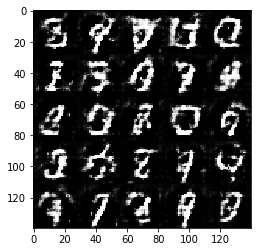

Epoch 1/2... Discriminator Loss: 1.6799... Generator Loss: 0.4666
Epoch 1/2... Discriminator Loss: 1.3618... Generator Loss: 0.6954
Epoch 1/2... Discriminator Loss: 1.7471... Generator Loss: 0.4970
Epoch 1/2... Discriminator Loss: 1.7682... Generator Loss: 1.2092
Epoch 1/2... Discriminator Loss: 1.5413... Generator Loss: 0.7830
Epoch 1/2... Discriminator Loss: 1.5069... Generator Loss: 0.7159
Epoch 1/2... Discriminator Loss: 1.4274... Generator Loss: 0.9220
Epoch 1/2... Discriminator Loss: 1.5073... Generator Loss: 0.8620
Epoch 1/2... Discriminator Loss: 1.5079... Generator Loss: 0.7559
Epoch 1/2... Discriminator Loss: 1.4175... Generator Loss: 0.8674
g z: Tensor("input_z:0", shape=(?, 128), dtype=float32)
g out_channel_dim 1
g fully connected: [None, 25088]
g x1: [None, 7, 7, 512]
g x2: [None, 7, 7, 256]
g x3: [None, 14, 14, 128]
g logit: [None, 28, 28, 1]


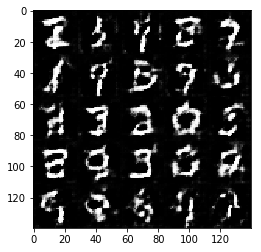

Epoch 1/2... Discriminator Loss: 1.5743... Generator Loss: 1.0191
Epoch 1/2... Discriminator Loss: 1.6000... Generator Loss: 0.6495
Epoch 1/2... Discriminator Loss: 1.5572... Generator Loss: 1.0525
Epoch 1/2... Discriminator Loss: 1.5231... Generator Loss: 0.5178
Epoch 1/2... Discriminator Loss: 1.7562... Generator Loss: 0.4571
Epoch 1/2... Discriminator Loss: 1.3922... Generator Loss: 0.9273
Epoch 1/2... Discriminator Loss: 1.5486... Generator Loss: 1.0827
Epoch 1/2... Discriminator Loss: 1.4091... Generator Loss: 0.7909
Epoch 1/2... Discriminator Loss: 1.4513... Generator Loss: 0.7688
Epoch 1/2... Discriminator Loss: 1.5207... Generator Loss: 0.6518
g z: Tensor("input_z:0", shape=(?, 128), dtype=float32)
g out_channel_dim 1
g fully connected: [None, 25088]
g x1: [None, 7, 7, 512]
g x2: [None, 7, 7, 256]
g x3: [None, 14, 14, 128]
g logit: [None, 28, 28, 1]


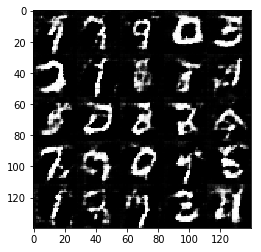

Epoch 1/2... Discriminator Loss: 1.6417... Generator Loss: 0.4459
Epoch 1/2... Discriminator Loss: 1.4666... Generator Loss: 0.6401
Epoch 1/2... Discriminator Loss: 1.4357... Generator Loss: 0.6246
Epoch 1/2... Discriminator Loss: 1.5292... Generator Loss: 1.2749
Epoch 1/2... Discriminator Loss: 1.4242... Generator Loss: 0.6154
Epoch 1/2... Discriminator Loss: 1.4932... Generator Loss: 0.6835
Epoch 1/2... Discriminator Loss: 1.5247... Generator Loss: 0.4728
Epoch 1/2... Discriminator Loss: 1.4865... Generator Loss: 1.1573
Epoch 1/2... Discriminator Loss: 1.5016... Generator Loss: 0.6897
Epoch 1/2... Discriminator Loss: 1.4848... Generator Loss: 0.9613
g z: Tensor("input_z:0", shape=(?, 128), dtype=float32)
g out_channel_dim 1
g fully connected: [None, 25088]
g x1: [None, 7, 7, 512]
g x2: [None, 7, 7, 256]
g x3: [None, 14, 14, 128]
g logit: [None, 28, 28, 1]


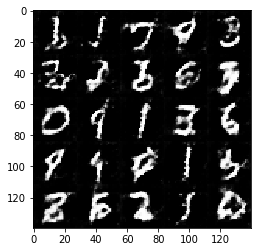

Epoch 1/2... Discriminator Loss: 1.5376... Generator Loss: 0.8989
Epoch 1/2... Discriminator Loss: 1.5762... Generator Loss: 0.4592
Epoch 1/2... Discriminator Loss: 1.4395... Generator Loss: 0.7216
Epoch 1/2... Discriminator Loss: 1.3940... Generator Loss: 0.9230
Epoch 1/2... Discriminator Loss: 1.5970... Generator Loss: 1.0522
Epoch 1/2... Discriminator Loss: 1.4302... Generator Loss: 0.7672
Epoch 1/2... Discriminator Loss: 1.5720... Generator Loss: 0.6333
Epoch 1/2... Discriminator Loss: 1.3985... Generator Loss: 1.0326
Epoch 1/2... Discriminator Loss: 1.4390... Generator Loss: 1.0099
Epoch 1/2... Discriminator Loss: 1.4950... Generator Loss: 1.1888
g z: Tensor("input_z:0", shape=(?, 128), dtype=float32)
g out_channel_dim 1
g fully connected: [None, 25088]
g x1: [None, 7, 7, 512]
g x2: [None, 7, 7, 256]
g x3: [None, 14, 14, 128]
g logit: [None, 28, 28, 1]


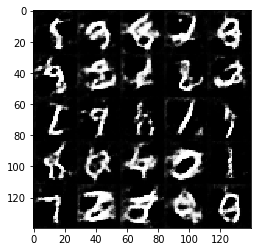

Epoch 1/2... Discriminator Loss: 1.5096... Generator Loss: 1.0790
Epoch 1/2... Discriminator Loss: 1.5053... Generator Loss: 1.2452
Epoch 1/2... Discriminator Loss: 1.4052... Generator Loss: 0.7837
Epoch 1/2... Discriminator Loss: 1.7517... Generator Loss: 0.3299
Epoch 1/2... Discriminator Loss: 1.4169... Generator Loss: 0.8910
Epoch 1/2... Discriminator Loss: 1.4845... Generator Loss: 0.9415
Epoch 1/2... Discriminator Loss: 1.5720... Generator Loss: 0.4358
Epoch 1/2... Discriminator Loss: 1.4721... Generator Loss: 0.6443
Epoch 1/2... Discriminator Loss: 1.6457... Generator Loss: 1.3953
Epoch 1/2... Discriminator Loss: 1.5142... Generator Loss: 0.6865
g z: Tensor("input_z:0", shape=(?, 128), dtype=float32)
g out_channel_dim 1
g fully connected: [None, 25088]
g x1: [None, 7, 7, 512]
g x2: [None, 7, 7, 256]
g x3: [None, 14, 14, 128]
g logit: [None, 28, 28, 1]


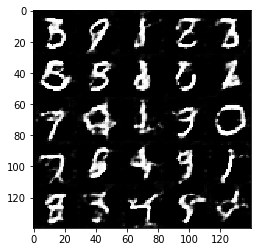

Epoch 1/2... Discriminator Loss: 1.4239... Generator Loss: 0.8617
Epoch 1/2... Discriminator Loss: 1.4068... Generator Loss: 0.5804
Epoch 1/2... Discriminator Loss: 1.4712... Generator Loss: 0.9163
Epoch 1/2... Discriminator Loss: 1.4448... Generator Loss: 0.7937
Epoch 1/2... Discriminator Loss: 1.4794... Generator Loss: 0.5576
Epoch 1/2... Discriminator Loss: 1.4156... Generator Loss: 0.9355
Epoch 1/2... Discriminator Loss: 1.5223... Generator Loss: 1.1251
Epoch 1/2... Discriminator Loss: 1.4649... Generator Loss: 0.6554
Epoch 1/2... Discriminator Loss: 1.7572... Generator Loss: 0.3675
Epoch 1/2... Discriminator Loss: 1.4223... Generator Loss: 0.7616
g z: Tensor("input_z:0", shape=(?, 128), dtype=float32)
g out_channel_dim 1
g fully connected: [None, 25088]
g x1: [None, 7, 7, 512]
g x2: [None, 7, 7, 256]
g x3: [None, 14, 14, 128]
g logit: [None, 28, 28, 1]


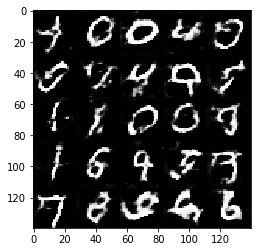

Epoch 1/2... Discriminator Loss: 1.8903... Generator Loss: 0.2756
Epoch 1/2... Discriminator Loss: 1.4869... Generator Loss: 0.6742
Epoch 1/2... Discriminator Loss: 1.6203... Generator Loss: 1.2510
Epoch 2/2... Discriminator Loss: 1.3434... Generator Loss: 0.7038
Epoch 2/2... Discriminator Loss: 1.6534... Generator Loss: 0.4068
Epoch 2/2... Discriminator Loss: 1.4060... Generator Loss: 0.6118
Epoch 2/2... Discriminator Loss: 1.6155... Generator Loss: 0.4580
Epoch 2/2... Discriminator Loss: 1.5825... Generator Loss: 0.4677
Epoch 2/2... Discriminator Loss: 1.5693... Generator Loss: 0.4607
Epoch 2/2... Discriminator Loss: 1.5134... Generator Loss: 0.5606
g z: Tensor("input_z:0", shape=(?, 128), dtype=float32)
g out_channel_dim 1
g fully connected: [None, 25088]
g x1: [None, 7, 7, 512]
g x2: [None, 7, 7, 256]
g x3: [None, 14, 14, 128]
g logit: [None, 28, 28, 1]


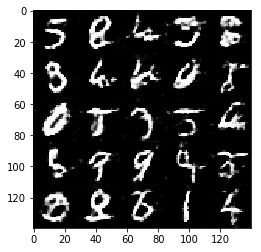

Epoch 2/2... Discriminator Loss: 1.3962... Generator Loss: 1.2830
Epoch 2/2... Discriminator Loss: 1.5317... Generator Loss: 1.1419
Epoch 2/2... Discriminator Loss: 1.5650... Generator Loss: 1.1561
Epoch 2/2... Discriminator Loss: 1.5009... Generator Loss: 0.9160
Epoch 2/2... Discriminator Loss: 1.3989... Generator Loss: 0.9586
Epoch 2/2... Discriminator Loss: 1.8437... Generator Loss: 0.3723
Epoch 2/2... Discriminator Loss: 1.3922... Generator Loss: 0.7747
Epoch 2/2... Discriminator Loss: 1.4555... Generator Loss: 1.0396
Epoch 2/2... Discriminator Loss: 1.5737... Generator Loss: 0.4641
Epoch 2/2... Discriminator Loss: 1.4942... Generator Loss: 0.5890
g z: Tensor("input_z:0", shape=(?, 128), dtype=float32)
g out_channel_dim 1
g fully connected: [None, 25088]
g x1: [None, 7, 7, 512]
g x2: [None, 7, 7, 256]
g x3: [None, 14, 14, 128]
g logit: [None, 28, 28, 1]


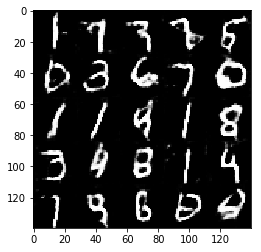

Epoch 2/2... Discriminator Loss: 1.4209... Generator Loss: 0.8588
Epoch 2/2... Discriminator Loss: 1.4001... Generator Loss: 0.9434
Epoch 2/2... Discriminator Loss: 1.8997... Generator Loss: 0.3290
Epoch 2/2... Discriminator Loss: 1.4293... Generator Loss: 0.6849


In [ ]:
batch_size = 64
z_dim = 128
learning_rate = 0.0008
beta1 = 0.5
# alpha value set inside generator and discriminator
# alpha = 0.2

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5
# alpha value set inside generator and discriminator
# alpha = 0.2

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.